In [4]:
import plenoptic as po
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


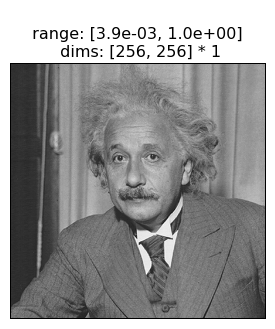

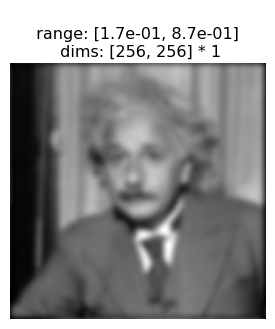

In [5]:
model = po.simul.Gaussian([30,30])
im = po.tools.load_images('../data/256/einstein.pgm')
fig = po.imshow(im)
h = model.forward(im)
fig=po.imshow(h)

In [10]:
synth = po.synthesize.SimpleMetamer(model,im)
s = synth.synthesize()

  0%|          | 0/100 [00:00<?, ?it/s]